In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

from hmmlearn.hmm import GaussianHMM, MultinomialHMM
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report



In [2]:
os.chdir('C:\\Users\\grace\\UNSW\\COMP4121\\COMP4121_MajorProject\\Data')

In [3]:
#Load datasets
raw_sales_df = pd.read_csv('raw_sales.csv', parse_dates=['datesold'])
ma_lga_df = pd.read_csv('ma_lga_12345.csv', parse_dates=['saledate'])

C:\Users\grace\AppData\Local\Temp\ipykernel_22032\3741783504.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ma_lga_df = pd.read_csv('ma_lga_12345.csv', parse_dates=['saledate'])


In [4]:
#Original data frames preview
print(raw_sales_df.head(5))
print(ma_lga_df.head(5))

    datesold  postcode   price propertyType  bedrooms
0 2007-02-07      2607  525000        house         4
1 2007-02-27      2906  290000        house         3
2 2007-03-07      2905  328000        house         3
3 2007-03-09      2905  380000        house         4
4 2007-03-21      2906  310000        house         3
    saledate      MA   type  bedrooms
0 2007-09-30  441854  house         2
1 2007-12-31  441854  house         2
2 2008-03-31  441854  house         2
3 2008-06-30  441854  house         2
4 2008-09-30  451583  house         2


In [5]:
# Step 1: Add year_quarter column to raw_sales_df and convert datesold to datetime
raw_sales_df['datesold'] = pd.to_datetime(raw_sales_df['datesold'])
raw_sales_df['year_quarter'] = raw_sales_df['datesold'].dt.year.astype(str) + '_Q' + raw_sales_df['datesold'].dt.quarter.astype(str)

# Step 2: Add year_quarter column to ma_lga_df and convert saledate to datetime
ma_lga_df['saledate'] = pd.to_datetime(ma_lga_df['saledate'])
ma_lga_df['year_quarter'] = ma_lga_df['saledate'].dt.year.astype(str) + '_Q' + ma_lga_df['saledate'].dt.quarter.astype(str)

In [6]:
# Step 3: Merge the dataframes on 'year_quarter', 'bedrooms', and 'type'
merged_df = pd.merge(
    raw_sales_df, 
    ma_lga_df[['year_quarter', 'type', 'bedrooms', 'MA']],  # Only the necessary columns from ma_lga_df
    how='left',  # Perform a left join to keep all rows from raw_sales_df
    left_on=['year_quarter', 'propertyType', 'bedrooms'],  # Merging keys
    right_on=['year_quarter', 'type', 'bedrooms']  # Merging keys in ma_lga_df
)

# Step 4: Rename columns to match raw_sales_df column names
merged_df = merged_df.rename(columns={
    'propertyType': 'property_type',  # Rename 'propertyType' to 'property_type'
    'datesold': 'date_sold'          # Rename 'datesold' to 'date_sold         # Fix duplicate column issue after merge
})

# Step 5: Drop 'property_type' column (duplicate after renaming)
merged_df['MA'] = merged_df['MA'].apply(lambda x: '{:.0f}'.format(x))
merged_df = merged_df.drop(columns=['type'])

# Step 6: Drop data entries with bedrooms = 0, since there are only 30 entries
merged_df = merged_df[merged_df['bedrooms'] != 0]

In [7]:
#import pandas as pd

# Assuming 'merged_df' is your DataFrame and 'date_sold' is the column with the sale dates

# Convert 'date_sold' to datetime if it's not already in datetime format
merged_df['date_sold'] = pd.to_datetime(merged_df['date_sold'])

# Sort by 'date_sold' to ensure data is in chronological order
merged_df = merged_df.sort_values(by='date_sold')

# Calculate the cutoff index for the 80-20 split
train_size = int(0.8 * len(merged_df))

# The cutoff date is the date of the observation at the 80% mark
cutoff_date = merged_df.iloc[train_size]['date_sold']
print(f"Cutoff Date for Test Set: {cutoff_date}")

# Split the data into train and test sets based on the cutoff date
train_df = merged_df[merged_df['date_sold'] < cutoff_date]
test_df = merged_df[merged_df['date_sold'] >= cutoff_date]

# Calculate 'normalized_price' and 'MA' on the training set only
train_df['normalized_price'] = train_df.groupby('year_quarter')['price'].transform(lambda x: x / x.median())
train_df['MA'] = train_df.groupby('year_quarter')['price'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

# Apply the same transformation to the test set based on the training data
test_df['normalized_price'] = test_df.groupby('year_quarter')['price'].transform(lambda x: x / train_df.groupby('year_quarter')['price'].median())
test_df['MA'] = test_df.groupby('year_quarter')['price'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

# Now you have your train and test sets split by date and correctly calculated features


Cutoff Date for Test Set: 2017-11-15 00:00:00


C:\Users\grace\AppData\Local\Temp\ipykernel_22032\3130938711.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['normalized_price'] = train_df.groupby('year_quarter')['price'].transform(lambda x: x / x.median())
C:\Users\grace\AppData\Local\Temp\ipykernel_22032\3130938711.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['MA'] = train_df.groupby('year_quarter')['price'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())
C:\Users\grace\AppData\Local\Temp\ipykernel_22032\313

Verify Train and Test is split correctly by dates before and after 2017

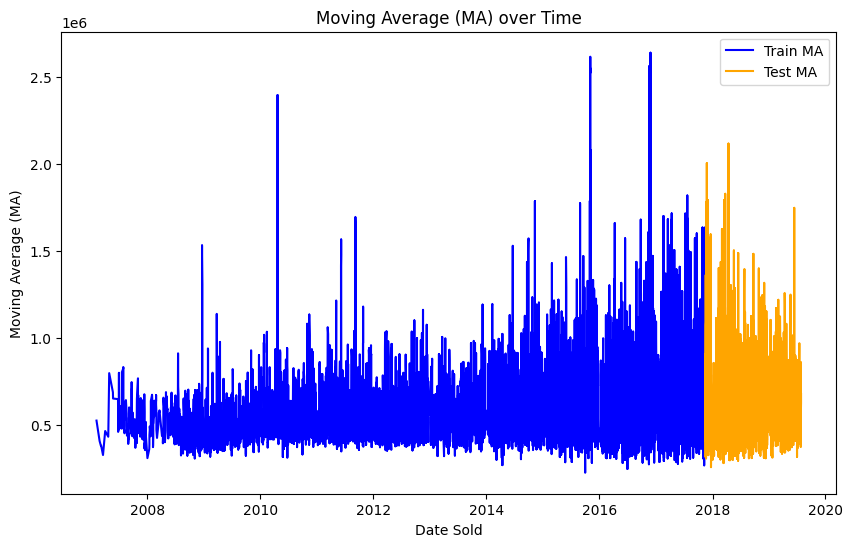

In [9]:
# Plot the MA over time for train and test data
plt.figure(figsize=(10, 6))

# Plot MA for train set
plt.plot(train_df['date_sold'], train_df['MA'], label='Train MA', color='blue')

# Plot MA for test set
plt.plot(test_df['date_sold'], test_df['MA'], label='Test MA', color='orange')

# Add labels and legend
plt.xlabel('Date Sold')
plt.ylabel('Moving Average (MA)')
plt.title('Moving Average (MA) over Time')
plt.legend()

plt.show()

Feature Engineering
- Mutated 'normalized_price'
    - Based on median price in a given year_sold x and bedroom y
        - 'normalized_price_median' = 'price' / 'median_price' 

Background
- Let the median price-based normalized price represent the price relative to the specific bedroom category and year.
- Let the MA-based normalized price represent the long-term market trend.

- A 'normalized_price' close to 1 represents a given property is close to a median or stable market price, greater than 1.2 represents price is 20% higher , etc.




In [11]:
#Step 1: Mutate 'year_sold'
train_df['year_sold'] = train_df['date_sold'].dt.year
train_df['month'] = train_df['date_sold'].dt.month

# Step 2: Group by year and number of bedrooms to calculate median price
median_price_by_bedrooms_year = train_df.groupby(['year_sold', 'bedrooms'])['price'].median().reset_index()
median_price_by_bedrooms_year.columns = ['year_sold', 'bedrooms', 'median_price']

# Step 3: convert 'median_price' and 'MA' to required float or int types
median_price_by_bedrooms_year['median_price'] = median_price_by_bedrooms_year['median_price'].astype('int64')
train_df['MA'] = pd.to_numeric(train_df['MA'], errors='coerce')

# Step 4: Merge 'merged_df' with 'median_price_by_bedrooms_year' on 'year_sold' and 'bedrooms'
train_df = pd.merge(train_df, median_price_by_bedrooms_year, on=['year_sold', 'bedrooms'], how='left')


#Step 1: Mutate 'year_sold'
test_df['year_sold'] = test_df['date_sold'].dt.year
test_df['month'] = test_df['date_sold'].dt.month

# Step 2: Group by year and number of bedrooms to calculate median price
median_price_by_bedrooms_year = test_df.groupby(['year_sold', 'bedrooms'])['price'].median().reset_index()
median_price_by_bedrooms_year.columns = ['year_sold', 'bedrooms', 'median_price']

# Step 3: convert 'median_price' and 'MA' to required float or int types
median_price_by_bedrooms_year['median_price'] = median_price_by_bedrooms_year['median_price'].astype('int64')
test_df['MA'] = pd.to_numeric(test_df['MA'], errors='coerce')

# Step 4: Merge 'merged_df' with 'median_price_by_bedrooms_year' on 'year_sold' and 'bedrooms'
test_df = pd.merge(test_df, median_price_by_bedrooms_year, on=['year_sold', 'bedrooms'], how='left')

C:\Users\grace\AppData\Local\Temp\ipykernel_22032\3603698873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['year_sold'] = train_df['date_sold'].dt.year
C:\Users\grace\AppData\Local\Temp\ipykernel_22032\3603698873.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['month'] = train_df['date_sold'].dt.month
C:\Users\grace\AppData\Local\Temp\ipykernel_22032\3603698873.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [13]:
train_df['normalized_price'] = train_df['price'] / train_df['median_price']
test_df['normalized_price'] = test_df['price'] / test_df['median_price']

print(merged_df.head(5))

   date_sold  postcode   price property_type  bedrooms year_quarter      MA
0 2007-02-07      2607  525000         house         4      2007_Q1  548969
1 2007-02-27      2906  290000         house         3      2007_Q1  421291
2 2007-03-07      2905  328000         house         3      2007_Q1  421291
3 2007-03-09      2905  380000         house         4      2007_Q1  548969
4 2007-03-21      2906  310000         house         3      2007_Q1  421291


In [15]:
train_df_prescaling = train_df[['date_sold', 'year_sold', 'price', 'bedrooms', 'year_quarter', 'MA', 'normalized_price']].dropna()
train_df = train_df[['date_sold', 'postcode', 'price', 'property_type', 'bedrooms', 'year_quarter', 'MA', 'normalized_price']].dropna()


Feature Engineering

- 'price_change'
- 'price_movement'
    - 0: Increasing (+1%)
    - 1: Decreasing (-1%)

In [17]:
train_df = train_df.sort_values(by=['year_quarter', 'bedrooms'])

# Calculate price change percentage by quarter
train_df['price_change'] = round(train_df.groupby(['year_quarter', 'bedrooms'])['price'].pct_change() * 100, 2)  # price_change in %

threshold = 1  # Define a threshold percentage (e.g., 1% increase or decrease)
train_df['price_movement'] = train_df['price_change'].apply(
    lambda x: 1 if x > threshold else (0 if x < -threshold else np.nan)
)
train_df = train_df.dropna(subset=['price_movement'])

In [ ]:
train_df.sort_values(by='date_sold', ascending=False)

train_df.head(5)

,date_sold,postcode,price,property_type,bedrooms,year_quarter,MA,normalized_price,price_change,price_movement
2,2007-03-07,2905,328000,house,3,2007_Q1,381000.0,0.771765,13.10,1.0
4,2007-03-21,2906,310000,house,3,2007_Q1,327000.0,0.729412,-5.49,0.0
3,2007-03-09,2905,380000,house,4,2007_Q1,380750.0,0.681004,-27.62,0.0
8,2007-05-24,2902,359000,house,3,2007_Q2,688250.0,0.844706,-10.03,0.0
9,2007-05-25,2906,320000,house,3,2007_Q2,652000.0,0.752941,-10.86,0.0
...,...,...,...,...,...,...,...,...,...,...
23550,2017-11-10,2904,895000,house,5,2017_Q4,846250.0,1.017045,6.55,1.0
23574,2017-11-11,2611,860000,house,5,2017_Q4,680375.0,0.977273,-3.91,0.0
23576,2017-11-11,2614,822000,house,5,2017_Q4,853500.0,0.934091,-4.42,0.0
23611,2017-11-14,2605,1000000,house,5,2017_Q4,851700.0,1.136364,21.65,1.0


In [20]:
train_df['year_quarter'] = train_df['year_quarter'].astype('category').cat.codes  # Encode 'propertyType' as numeric
train_df['normalized_price'] = train_df['normalized_price'].astype('category').cat.codes
train_df['property_type'] = train_df['property_type'].astype('category').cat.codes
train_df['postcode'] = train_df['postcode'].astype('category').cat.codes
train_df['price_movement'] = train_df['price_movement'].astype('category').cat.codes

In [ ]:
train_df.head(5)

,date_sold,postcode,price,property_type,bedrooms,year_quarter,MA,normalized_price,price_change,price_movement
2,2007-03-07,21,328000,0,3,0,381000.0,1012,13.10,1
4,2007-03-21,22,310000,0,3,0,327000.0,652,-5.49,0
3,2007-03-09,21,380000,0,4,0,380750.0,356,-27.62,0
8,2007-05-24,18,359000,0,3,1,688250.0,1920,-10.03,0
9,2007-05-25,22,320000,0,3,1,652000.0,837,-10.86,0
...,...,...,...,...,...,...,...,...,...,...
23550,2017-11-10,20,895000,0,5,43,846250.0,4475,6.55,1
23574,2017-11-11,9,860000,0,5,43,680375.0,3901,-3.91,0
23576,2017-11-11,11,822000,0,5,43,853500.0,3262,-4.42,0
23611,2017-11-14,5,1000000,0,5,43,851700.0,5871,21.65,1


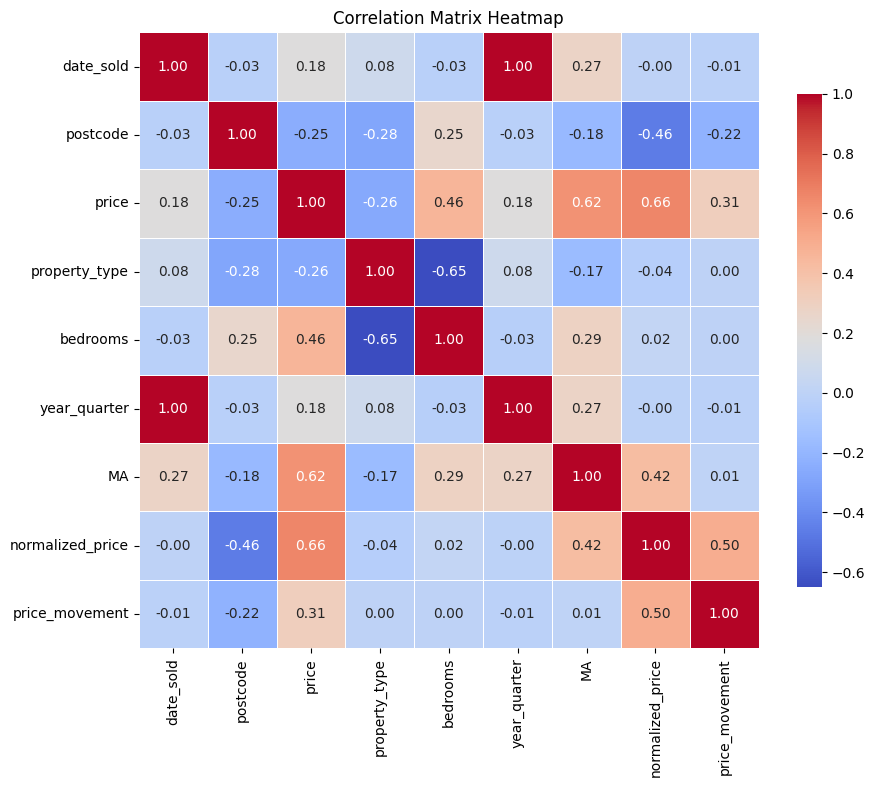

In [22]:
corr_matrix = train_df[['date_sold', 'postcode', 'price', 'property_type', 'bedrooms', 'year_quarter', 'MA', 'normalized_price', 'price_movement']].corr()

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create the heatmap with annotations and a color map (e.g., 'coolwarm')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': .8})

# Add a title
plt.title('Correlation Matrix Heatmap')

# Display the heatmap
plt.show()

In [ ]:
# Define the features (X) and target (y) for training and testing
train_df['price_movement'] = (train_df['price'].shift(-1) > train_df['price']).astype(int)  # Example logic
test_df['price_movement'] = (test_df['price'].shift(-1) > test_df['price']).astype(int)    # Example logic


X_train = train_df[['normalized_price', 'MA', 'bedrooms']]  # Features for training
y_train = train_df['price_movement']  # Target for training

X_test = test_df[['normalized_price', 'MA', 'bedrooms']]  # Features for testing
y_test = test_df['price_movement']  # Target for testing

# Convert to numpy arrays if required by your model
X_train = X_train.to_numpy()  # or X_train.values
X_test = X_test.to_numpy()  # or X_test.values

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test = scaler.transform(X_test)

In [ ]:
#Verify correct length
print(len(X_train))
print(len(train_df))

22430
22430


3. Determine Optimal Number of Hidden States:
- Train HMM for multiple n states
- Evaluate Log-likelihood
- Use AIC/BIC for Model Selection


I am modeling categorical states (price movement), so I will be using MultinomialHMM

In [27]:
#Step 3: Determine Optimal Number of Hidden States

# Discretize features into 10 bins (adjust bins as needed)
#discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=None)
#X_train_discretized = discretizer.fit_transform(X_train)

# Example: Iterate over different n states to find the optimal number
def find_optimal_states(features, max_states):
    aic_scores = []
    bic_scores = []
    models = []
    
    for n_states in range(2, max_states + 1):  # Test models with 2 to max_states
        hmm = GaussianHMM(n_components=n_states, random_state=42, n_iter=100)
        hmm.fit(features)
        models.append(hmm)
        
        # Calculate log likelihood
        log_likelihood = hmm.score(features)
        num_params = n_states**2 + 2 * n_states * features.shape[1] - 1 # Number of parameters
        
        # Calculate AIC and BIC
        aic = 2 * num_params - 2 * log_likelihood
        bic = np.log(len(features)) * num_params - 2 * log_likelihood
        
        aic_scores.append(aic)
        bic_scores.append(bic)
    
    # Find optimal number of states
    optimal_states_aic = 2 + np.argmin(aic_scores)
    optimal_states_bic = 2 + np.argmin(bic_scores)
    
    return optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models

#optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models = find_optimal_states(features=X_train_discretized, max_states=10)
optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models = find_optimal_states(features=X_train, max_states=10)

print(f"Optimal number of states based on AIC: {optimal_states_aic}")
print(f"Optimal number of states based on BIC: {optimal_states_bic}")

Model is not converging.  Current: 42947.5917609398 is not greater than 42947.68712845241. Delta is -0.09536751260748133


Optimal number of states based on AIC: 9
Optimal number of states based on BIC: 9


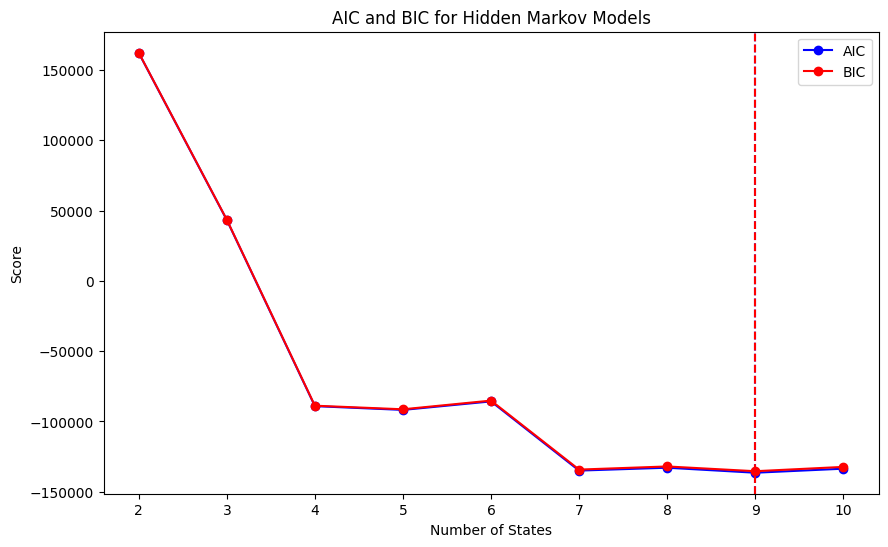

In [28]:
# Plot AIC and BIC
states_range = range(2, len(aic_scores) + 2)

plt.figure(figsize=(10, 6))
plt.plot(states_range, aic_scores, marker='o', label='AIC', color='blue')
plt.plot(states_range, bic_scores, marker='o', label='BIC', color='red')
plt.axvline(optimal_states_aic, color='blue', linestyle='--')
plt.axvline(optimal_states_bic, color='red', linestyle='--')
#plt.axvline(optimal_states_aic, color='blue', linestyle='--', label=f'Optimal States (AIC): {optimal_states_aic}')
#plt.axvline(optimal_states_bic, color='red', linestyle='--', label=f'Optimal States (BIC): {optimal_states_bic}')
plt.xlabel('Number of States')
plt.ylabel('Score')
plt.title('AIC and BIC for Hidden Markov Models')
plt.legend()
plt.show()

4. Train HMM with Optimal n States

- We found optimal n = 5

In [29]:
# Step 4: Train HMM on aggregated data
optimal_n = 7
hmm_model = GaussianHMM(n_components=optimal_n, n_iter=1000, random_state=42)  # 3 states: Decrease, Stable, Increase
#hmm_model.fit(X_train_discretized)
hmm_model.fit(X_train)

GaussianHMM(n_components=7, n_iter=1000, random_state=42)

5. Predict Hidden States for Partitioning

In [30]:
# Predict the hidden states
#hidden_states = hmm_model.predict(X_train_discretized)
hidden_states = hmm_model.predict(X_train)
hidden_states_test = hmm_model.predict(X_test)

# Create DataFrame with discretized features and hidden states
#X_train_df = pd.DataFrame(X_train_discretized, columns=['normalized_price', 'MA', 'bedrooms'])
X_train_df = pd.DataFrame(X_train, columns=['normalized_price', 'MA', 'bedrooms'])
X_train_df['hidden_state'] = hidden_states

X_test_df = pd.DataFrame(X_test, columns=['normalized_price', 'MA', 'bedrooms'])
X_test_df['hidden_state'] = hidden_states_test

6. Incorporate Hidden States into Classification
- Models:
    - Random Forest Classifier
    

In [31]:
#Train Random Forest Classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_train)

RandomForestClassifier(random_state=42)

In [33]:
# Check for missing values in the test data
print(X_test_df.isnull().sum())


normalized_price    0
MA                  0
bedrooms            0
hidden_state        0
dtype: int64


In [34]:
X_test_df

,normalized_price,MA,bedrooms,hidden_state
0,-1.780490,0.894922,0.780078,4
1,-1.780568,0.036360,-0.312879,5
2,-1.780243,1.199573,0.780078,0
3,-1.780558,0.714901,-0.312879,5
4,-1.780549,0.323009,-0.312879,5
...,...,...,...,...
5926,-1.780525,0.164452,0.780078,0
5927,-1.780317,-0.093117,-1.405836,1
5928,-1.780551,0.100752,0.780078,0
5929,-1.780531,0.152681,0.780078,0


In [ ]:
# --- 1. Logistic Regression ---
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
logreg_predictions = logreg.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# --- 2. Support Vector Machine (SVM) ---
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
svm_predictions = svm.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# --- 3. K-Nearest Neighbors (KNN) ---
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
knn_predictions = knn.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# --- 4. Decision Tree ---
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
dtree_predictions = dtree.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# --- 5. Gradient Boosting ---
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
gbc_predictions = gbc.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])


K-Nearest Neighbors Performance:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2998
           1       0.74      0.74      0.74      2933

    accuracy                           0.74      5931
   macro avg       0.74      0.74      0.74      5931
weighted avg       0.74      0.74      0.74      5931

Decision Tree Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2998
           1       1.00      1.00      1.00      2933

    accuracy                           1.00      5931
   macro avg       1.00      1.00      1.00      5931
weighted avg       1.00      1.00      1.00      5931

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72      2998
           1       0.72      0.67      0.69      2933

    accuracy                           0.71      5931
   macro avg       0.71      0.71    

In [36]:
# Logistic Regression Evaluation
print("Logistic Regression Performance:")
print(classification_report(y_test, logreg_predictions))

# Support Vector Machine Evaluation
print("Support Vector Machine Performance:")
print(classification_report(y_test, svm_predictions))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.65      0.64      0.65      2998
           1       0.64      0.65      0.64      2933

    accuracy                           0.65      5931
   macro avg       0.65      0.65      0.65      5931
weighted avg       0.65      0.65      0.65      5931

Support Vector Machine Performance:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      2998
           1       0.65      0.65      0.65      2933

    accuracy                           0.66      5931
   macro avg       0.66      0.66      0.66      5931
weighted avg       0.66      0.66      0.66      5931



In [ ]:
# K-Nearest Neighbors Evaluation
print("K-Nearest Neighbors Performance:")
print(classification_report(y_test, knn_predictions))

# Decision Tree Evaluation
print("Decision Tree Performance:")
print(classification_report(y_test, dtree_predictions))

# Gradient Boosting Evaluation
print("Gradient Boosting Performance:")
print(classification_report(y_test, gbc_predictions))

Comparing with and without HMM feature

In [ ]:
#Without 'hidden_state' feature

# --- 3. K-Nearest Neighbors (KNN) ---
from sklearn.neighbors import KNeighborsClassifier
knn_bl = KNeighborsClassifier()
knn_bl.fit(X_test_df[['normalized_price', 'MA', 'bedrooms']], y_test)
baseline_knn_predictions = knn_bl.predict(X_test_df[['normalized_price', 'MA', 'bedrooms']])

# --- 4. Decision Tree ---
from sklearn.tree import DecisionTreeClassifier
dtree_bl = DecisionTreeClassifier(random_state=42)
dtree_bl.fit(X_test_df[['normalized_price', 'MA', 'bedrooms']], y_test)
baseline_dtree_predictions = dtree_bl.predict(X_test_df[['normalized_price', 'MA', 'bedrooms']])

# --- 5. Gradient Boosting ---
from sklearn.ensemble import GradientBoostingClassifier
gbc_bl = GradientBoostingClassifier(random_state=42)
gbc_bl.fit(X_test_df[['normalized_price', 'MA', 'bedrooms']], y_test)
baseline_gbc_predictions = gbc_bl.predict(X_test_df[['normalized_price', 'MA', 'bedrooms']])

In [ ]:
#With 'hidden_state' feature

# --- 3. K-Nearest Neighbors (KNN) ---
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
knn_predictions = knn.predict(X_test_df[['normalized_price', 'MA', 'bedrooms','hidden_state']])

# --- 4. Decision Tree ---
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_test_df[['normalized_price', 'MA','bedrooms', 'hidden_state']], y_test)
dtree_predictions = dtree.predict(X_test_df[['normalized_price', 'MA','bedrooms', 'hidden_state']])

# --- 5. Gradient Boosting ---
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_test_df[['normalized_price', 'MA', 'bedrooms','hidden_state']], y_test)
gbc_predictions = gbc.predict(X_test_df[['normalized_price', 'MA', 'bedrooms','hidden_state']])



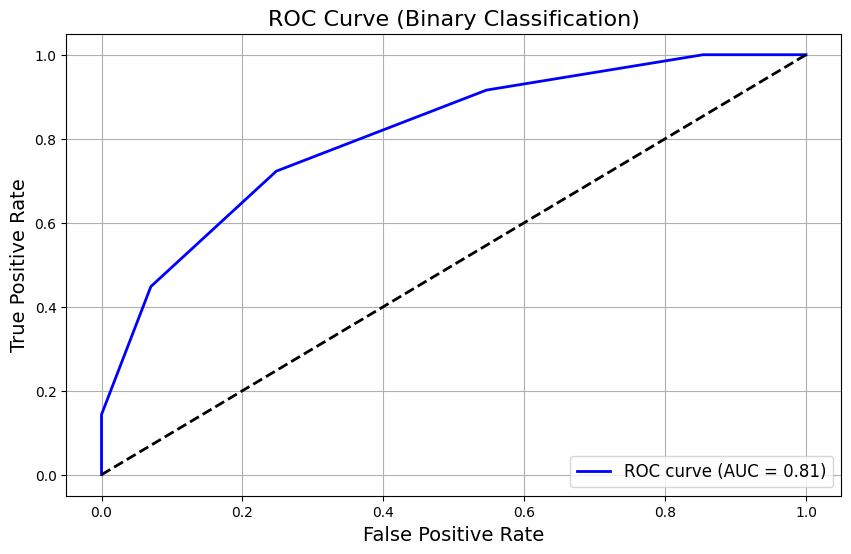

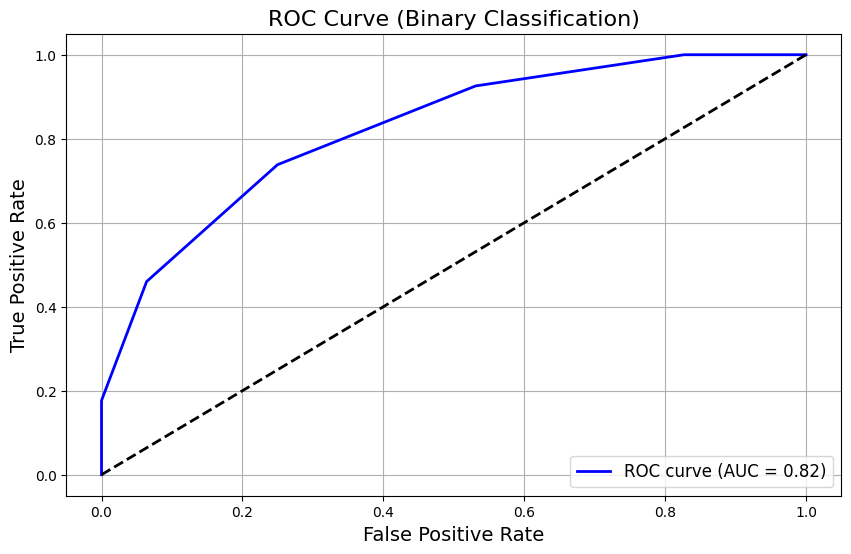

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve_binary(y_true, y_proba):
    """


    Plots the ROC curve for binary classification predictions.

    Parameters:
    - y_true: Array-like, true labels (binary)
    - y_proba: Array-like, predicted probabilities for the positive class

    Output:
    - Displays the ROC curve with AUC score.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    plt.title("ROC Curve (Binary Classification)", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid()
    plt.show()

knn_probabilities_bl = knn_bl.predict_proba(X_test_df[['normalized_price', 'MA', 'bedrooms']])[:, 1]
plot_roc_curve_binary(y_test, knn_probabilities_bl)


knn_probabilities_hmm = knn.predict_proba(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])[:, 1]
plot_roc_curve_binary(y_test, knn_probabilities_hmm)


In [44]:

print("Model without Hidden States:")
print(classification_report(y_test, baseline_knn_predictions))
print(classification_report(y_test, baseline_dtree_predictions))
print(classification_report(y_test, baseline_gbc_predictions))

Model without Hidden States:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      2998
           1       0.74      0.72      0.73      2933

    accuracy                           0.74      5931
   macro avg       0.74      0.74      0.74      5931
weighted avg       0.74      0.74      0.74      5931

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2998
           1       1.00      1.00      1.00      2933

    accuracy                           1.00      5931
   macro avg       1.00      1.00      1.00      5931
weighted avg       1.00      1.00      1.00      5931

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      2998
           1       0.71      0.68      0.70      2933

    accuracy                           0.71      5931
   macro avg       0.71      0.71      0.71      5931
weighted avg       0.71      0.71      0.71  

In [ ]:
print("Model with Hidden States:")
print(classification_report(y_test, knn_predictions))
print(classification_report(y_test, dtree_predictions))
print(classification_report(y_test, gbc_predictions))

Model with Hidden States:
              precision    recall  f1-score   support

           0       0.77      0.66      0.71      1663
           1       0.86      0.91      0.89      3883

    accuracy                           0.84      5546
   macro avg       0.81      0.79      0.80      5546
weighted avg       0.83      0.84      0.83      5546

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1663
           1       0.99      0.97      0.98      3883

    accuracy                           0.97      5546
   macro avg       0.96      0.98      0.97      5546
weighted avg       0.98      0.97      0.97      5546

              precision    recall  f1-score   support

           0       0.74      0.61      0.67      1663
           1       0.84      0.91      0.88      3883

    accuracy                           0.82      5546
   macro avg       0.79      0.76      0.77      5546
weighted avg       0.81      0.82      0.81     